In [20]:
import sys
import gc
import os 
import re 
import csv
import time
import codecs

import numpy as np
import pandas as pd

import logging
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten, Conv1D, BatchNormalization, GRU
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam, RMSprop

from tqdm import tqdm_notebook

start_time = time.time()
np.random.seed(32)
os.environ["OMP_NUM_THREADS"] = "4"

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
class F1Evaluation(Callback):
    def __init__(self, validation_data=(), test_data=(), interval=1):
        super(Callback, self).__init__()
        
        self.interval = interval
        self.X_val, self.y_val = validation_data
        self.X_test, self.y_test = test_data
        self.y_val = self.y_val[:, 1]
        self.y_test = self.y_test[:, 1]
        self.T = 0.5
    
    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_val = self.model.predict(self.X_val, verbose=0)[:, 1]
            y_test = self.model.predict(self.X_test, verbose=0)[:, 1]
            y_val[y_val >= self.T] = 1
            y_val[y_val < self.T] = 0
            y_test[y_test >= self.T] = 1
            y_test[y_test < self.T] = 0
            
            val_score = f1_score(self.y_val, y_val)
            test_score = f1_score(self.y_test, y_test)
            print("F1 : Epoch : {} \t Valid Score : {:.4f} \t Test Score : {:.4f}".format(epoch+1, val_score, test_score))

In [8]:
def get_data():
    train = pd.read_csv("../input/avlpp-2/train_ne.csv")
    test = pd.read_csv("../input/avalaraproduct-classification/test_ne_imputed.csv")
    print("Train Shape : {}\nTest Shape :  {}".format(train.shape, test.shape))
    
    train = train[['fold_id', 'title', 'description', 'text', 'category', 'source']]
    test = test[['title', 'description', 'text', 'category']]
    train.dropna(inplace=True)
    
    return train, test

In [9]:
train, test = get_data()
target = 'category'

Train Shape : (1199998, 6)
Test Shape :  (92, 5)


In [10]:
train.head()

,fold_id,title,description,text,category,source
0,1,ziczac black red euro 44,clothing related products b2c shoes shoe laces,ziczac black red euro 44 clothing related prod...,R,valid
1,1,9x9 resista 484938,publishing printing printing services,9x9 resista 484938 publishing printing printin...,S,train
2,1,halle pant short inseam 013049561d0010001 02,clothing related products b2c general,halle pant short inseam 013049561d0010001 02 c...,R,train
3,1,harry houser travel expenses meals,security personnel,harry houser travel expenses meals security pe...,S,train
4,1,tee time 740078609 greens fee composite,admissions green fees privately owned golf course,tee time 740078609 greens fee composite admiss...,R,valid


In [11]:
K = 6

In [12]:
list_classes = ["target_R", "target_S"]

train[target] = train[target].map({"R": 0, "S": 1})
train['target_S'] = np.nan
train['target_R'] = np.nan
train['target_R'] = 1 - train[target].values
train['target_S'] = train[target].values

train.drop([target], axis=1, inplace=True)

In [13]:
test[target] = test[target].map({"R": 0, "S": 1})
test['target_S'] = np.nan
test['target_R'] = np.nan
test['target_R'] = 1 - test[target].values
test['target_S'] = test[target].values

test.drop([target], axis=1, inplace=True)

In [14]:
### Splitter

def splitter(data, k=K):
    
    data_v1 = data[data['fold_id'] == k].copy()
    data_v1.reset_index(drop=True, inplace=True)
    
    train_set = data_v1[data_v1['source'] == 'train'].copy()
    valid_set = data_v1[data_v1['source'] == 'valid'].copy()
    train_set.reset_index(drop=True, inplace=True)
    valid_set.reset_index(drop=True, inplace=True)
    
    del data_v1
    gc.collect()
    
#     print(train_set.shape, valid_set.shape)
    
    return train_set, valid_set, train_set[list_classes].values, valid_set[list_classes].values

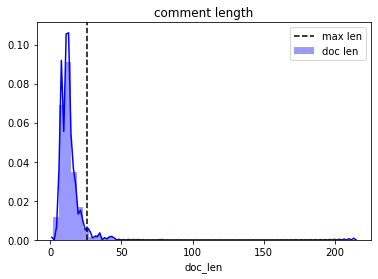

In [15]:
# visualize word length distribution
train['doc_len'] = train['text'].apply(lambda words: len(words.split(" ")))
max_len = np.round(train['doc_len'].mean() + 2*train['doc_len'].std()).astype(int)

sns.distplot(train['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_len, color='k', linestyle='--', label='max len')
plt.title('comment length')
plt.legend()
plt.show()

In [16]:
max_len

26

In [17]:
embed_size = 300
embedding_path = "../input/glove840b300dtxt/glove.840B.300d.txt"
max_features = 100000
max_len = 50

BS = 128

In [22]:
y_test = test[list_classes].values

X_train, X_valid, y_new_train, y_new_valid = splitter(train)
print(X_train.shape, X_valid.shape, y_new_train.shape, y_new_valid.shape)

(99371, 8) (20593, 8) (99371, 2) (20593, 2)


In [23]:
raw_text_train = X_train['text'].str.lower()
raw_text_valid = X_valid['text'].str.lower()
raw_text_test = test['text'].str.lower()

In [24]:
%%time

tk = Tokenizer(num_words=max_features, lower=True)
tk.fit_on_texts(raw_text_train.values.tolist() + raw_text_valid.values.tolist() + test['text'].values.tolist())
X_train['seq'] = tk.texts_to_sequences(raw_text_train.values)
X_valid['seq'] = tk.texts_to_sequences(raw_text_valid.values)
test['seq'] = tk.texts_to_sequences(raw_text_test.values)

X_train = pad_sequences(X_train.seq, maxlen=max_len)
X_valid = pad_sequences(X_valid.seq, maxlen=max_len)
test = pad_sequences(test.seq, maxlen=max_len)

CPU times: user 6.81 s, sys: 54.4 ms, total: 6.87 s
Wall time: 6.93 s


### Glove Baselining

In [41]:
%%time

# GloVE
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype="float32")
embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path))

CPU times: user 4min 40s, sys: 7.03 s, total: 4min 47s
Wall time: 4min 47s


In [42]:
word_index = tk.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = np.zeros((nb_words, embed_size))
cnt = 0
for word, i in tqdm_notebook(word_index.items()):
    if i>= nb_words:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        cnt += 1

cov = (cnt / nb_words)*100
print("Number of words : {}".format(nb_words))
print("Coverage : {:.2f}".format(cov))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Number of words : 100000
Coverage : 28.82


## Modelling Utils

In [43]:
N_EPOCHS = 5

## CNN

In [44]:
def build_model_cnn(test, embedding_matrix, lr=0.0, lr_d=0.0, units=0, dr=0.0, filename="cnn"):
    
    file_path = "cnn-{epoch:02d}.hdf5"
    check_point = ModelCheckpoint(file_path, monitor="val_loss", verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)
    f1_val = F1Evaluation(validation_data=(X_valid, y_new_valid), test_data=(test, y_test), interval=1)
    early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)

    inp = Input(shape=(max_len, ))

    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = Conv1D(128, 3, activation='relu')(x)
    x = MaxPooling1D(3)(x)
    x = Dropout(0.2)(x)
    x = Conv1D(64, 3, activation='relu')(x)
    x = MaxPooling1D(3)(x)
    x = Dropout(0.2)(x)
    x = Conv1D(64, 3, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Flatten()(x)
    x = Dense(2, activation='sigmoid')(x)
    
    model = Model(inputs=inp, outputs=x)
    model.compile(loss="binary_crossentropy", optimizer=Adam(lr=lr, decay=lr_d), metrics=['accuracy'])
    history = model.fit(X_train, y_new_train, batch_size=BS, epochs=N_EPOCHS, validation_data=(X_valid, y_new_valid), verbose=1, 
                        callbacks=[f1_val, check_point, early_stop])
    preds = model.predict(test, batch_size=1024, verbose=1)[:, 1]
    
    return model, preds

In [45]:
lr = 1e-3
lr_d = 0
units = 128
dr = 0.2

model, preds = build_model_cnn(test, embedding_matrix, lr, lr_d, units, dr, filename="cnn")

Train on 99371 samples, validate on 20593 samples
Epoch 1/5
99371/99371 [==============================] - 6s 57us/step - loss: 0.1861 - accuracy: 0.9076 - val_loss: 0.3564 - val_accuracy: 0.8594
F1 : Epoch : 1 	 Valid Score : 0.9020 	 Test Score : 0.8430

Epoch 00001: saving model to cnn-01.hdf5
Epoch 2/5
99371/99371 [==============================] - 5s 49us/step - loss: 0.1409 - accuracy: 0.9259 - val_loss: 0.4974 - val_accuracy: 0.8166
F1 : Epoch : 2 	 Valid Score : 0.8667 	 Test Score : 0.8430

Epoch 00002: saving model to cnn-02.hdf5
Epoch 3/5
99371/99371 [==============================] - 5s 49us/step - loss: 0.1259 - accuracy: 0.9306 - val_loss: 0.4154 - val_accuracy: 0.8544
F1 : Epoch : 3 	 Valid Score : 0.9015 	 Test Score : 0.8430

Epoch 00003: saving model to cnn-03.hdf5
Epoch 4/5
99371/99371 [==============================] - 5s 47us/step - loss: 0.1161 - accuracy: 0.9341 - val_loss: 0.5109 - val_accuracy: 0.8269
F1 : Epoch : 4 	 Valid Score : 0.8756 	 Test Score : 0.8361


In [28]:
sub = pd.DataFrame()
sub['glove_pre'] = np.nan
sub['fasttext_pre'] = np.nan
sub['word2vec_pre'] = np.nan

In [47]:
epoch_id = 5
model_path = "cnn-0{}.hdf5".format(epoch_id)
model.load_weights(model_path)
preds = model.predict(test, batch_size=1024, verbose=1)[:, 1]
sub['glove_pre'] = preds
sub.head()

92/92 [==============================] - 0s 26us/step


,glove_pre,fasttext_pre,word2vec_pre
0,0.668374,0.513431,0.467357
1,0.985637,0.864065,0.287055
2,0.999998,0.999983,0.999927
3,1.000000,0.999967,0.999992
4,0.605352,0.844581,0.091629


## GloVe : 

Coverage : 28.90 (What??? This might be due to the higher unique words which could be Company names and service names which are very domain-specific (services and prodcuts) domain).

Best Test - F1 : 0.8689 (Well lesser than our BOW words models)

PS : **baselined by CNN becuase it veryyyy fast**

### Word2Vec

In [29]:
# Word2Vec
import gensim.models.keyedvectors as word2vec

word2vecDict = word2vec.KeyedVectors.load_word2vec_format("../input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin", binary=True)
embedding_index = dict()
for word in word2vecDict.wv.vocab:
    embedding_index[word] = word2vecDict.word_vec(word)
print('Loaded {} word vectors.'.format(len(embedding_index)))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


Loaded 3000000 word vectors.


In [30]:
word_index = tk.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = np.zeros((nb_words, embed_size))
cnt = 0
for word, i in tqdm_notebook(word_index.items()):
    if i>= nb_words:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        cnt += 1

cov = (cnt / nb_words)*100
print("Number of words : {}".format(nb_words))
print("Coverage : {:.2f}".format(cov))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Number of words : 100000
Coverage : 17.65


In [34]:
lr = 1e-3
lr_d = 0
units = 128
dr = 0.2

model, preds = build_model_cnn(test, embedding_matrix, lr, lr_d, units, dr, filename="cnn")

Train on 99371 samples, validate on 20593 samples
Epoch 1/5
99371/99371 [==============================] - 5s 51us/step - loss: 0.2018 - accuracy: 0.8963 - val_loss: 0.4103 - val_accuracy: 0.7953
F1 : Epoch : 1 	 Valid Score : 0.8497 	 Test Score : 0.8525

Epoch 00001: saving model to cnn-01.hdf5
Epoch 2/5
99371/99371 [==============================] - 5s 48us/step - loss: 0.1543 - accuracy: 0.9171 - val_loss: 0.5569 - val_accuracy: 0.7812
F1 : Epoch : 2 	 Valid Score : 0.8372 	 Test Score : 0.8595

Epoch 00002: saving model to cnn-02.hdf5
Epoch 3/5
99371/99371 [==============================] - 5s 52us/step - loss: 0.1387 - accuracy: 0.9218 - val_loss: 0.5714 - val_accuracy: 0.7475
F1 : Epoch : 3 	 Valid Score : 0.8076 	 Test Score : 0.8099

Epoch 00003: saving model to cnn-03.hdf5
Epoch 4/5
99371/99371 [==============================] - 5s 51us/step - loss: 0.1290 - accuracy: 0.9261 - val_loss: 0.6144 - val_accuracy: 0.7902
F1 : Epoch : 4 	 Valid Score : 0.8462 	 Test Score : 0.8595


In [36]:
epoch_id = 4
model_path = "cnn-0{}.hdf5".format(epoch_id)
model.load_weights(model_path)
preds = model.predict(test, batch_size=1024, verbose=1)[:, 1]
sub['word2vec_pre'] = preds
sub.head()

92/92 [==============================] - 0s 33us/step


,glove_pre,fasttext_pre,word2vec_pre
0,NaN,NaN,0.467357
1,NaN,NaN,0.287055
2,NaN,NaN,0.999927
3,NaN,NaN,0.999992
4,NaN,NaN,0.091629


## Word2Vec : 

Coverage : 17.65

Best Test - F1 : **0.8595**

PS : **baselined by CNN becuase it veryyyy fast**

### FastText

In [37]:
# FastText
embedding_index = {}
f = codecs.open('../input/fasttext/wiki.simple.vec', encoding='utf-8')
for line in tqdm_notebook(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
f.close()
print('Loaded {} word vectors'.format(len(embedding_index)))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Loaded 111052 word vectors


In [38]:
word_index = tk.word_index
nb_words = min(max_features, len(word_index))

embedding_matrix = np.zeros((nb_words, embed_size))
cnt = 0
for word, i in tqdm_notebook(word_index.items()):
    if i>= nb_words:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        cnt += 1

cov = (cnt / nb_words)*100
print("Number of words : {}".format(nb_words))
print("Coverage : {:.2f}".format(cov))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



Number of words : 100000
Coverage : 17.18


In [39]:
lr = 1e-3
lr_d = 0
units = 128
dr = 0.2

model, preds = build_model_cnn(test, embedding_matrix, lr, lr_d, units, dr, filename="cnn")

Train on 99371 samples, validate on 20593 samples
Epoch 1/5
99371/99371 [==============================] - 5s 53us/step - loss: 0.2068 - accuracy: 0.8927 - val_loss: 0.5973 - val_accuracy: 0.7326
F1 : Epoch : 1 	 Valid Score : 0.7956 	 Test Score : 0.8067

Epoch 00001: saving model to cnn-01.hdf5
Epoch 2/5
99371/99371 [==============================] - 5s 46us/step - loss: 0.1585 - accuracy: 0.9125 - val_loss: 0.5578 - val_accuracy: 0.7494
F1 : Epoch : 2 	 Valid Score : 0.8089 	 Test Score : 0.8160

Epoch 00002: saving model to cnn-02.hdf5
Epoch 3/5
99371/99371 [==============================] - 5s 49us/step - loss: 0.1425 - accuracy: 0.9185 - val_loss: 0.6832 - val_accuracy: 0.7399
F1 : Epoch : 3 	 Valid Score : 0.8001 	 Test Score : 0.8130

Epoch 00003: saving model to cnn-03.hdf5
Epoch 4/5
99371/99371 [==============================] - 5s 46us/step - loss: 0.1334 - accuracy: 0.9216 - val_loss: 0.5942 - val_accuracy: 0.8012
F1 : Epoch : 4 	 Valid Score : 0.8548 	 Test Score : 0.7899


In [40]:
epoch_id = 2
model_path = "cnn-0{}.hdf5".format(epoch_id)
model.load_weights(model_path)
preds = model.predict(test, batch_size=1024, verbose=1)[:, 1]
sub['fasttext_pre'] = preds
sub.head()

92/92 [==============================] - 0s 25us/step


,glove_pre,fasttext_pre,word2vec_pre
0,NaN,0.513431,0.467357
1,NaN,0.864065,0.287055
2,NaN,0.999983,0.999927
3,NaN,0.999967,0.999992
4,NaN,0.844581,0.091629


## FastText : 

Coverage : 17.32

Best F1 Test Score : **0.8160**

PS : **baselined by CNN**

In [ ]:
sub.to_csv("pretrained_emb.csv", index=False)

# Compute-Heavy Approach to increase the coverage

This might increase the coverage of the pre-trained embeddings most probably leading to an increase in F1 as well.

In [46]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from nltk.stem.lancaster import LancasterStemmer
lc = LancasterStemmer()
from nltk.stem import SnowballStemmer
sb = SnowballStemmer("english")

def load_glove(word_dict, lemma_dict):
    EMBEDDING_FILE = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    embed_size = 300
    nb_words = len(word_dict)+1
    embedding_matrix = np.zeros((nb_words, embed_size), dtype=np.float32)
    unknown_vector = np.zeros((embed_size,), dtype=np.float32) - 1.
    print(unknown_vector[:5])
    for key in tqdm(word_dict):
        word = key
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = key.lower()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = key.upper()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = key.capitalize()
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = ps.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = lc.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = sb.stem(key)
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        word = lemma_dict[key]
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[word_dict[key]] = embedding_vector
            continue
        if len(key) > 1:
            word = correction(key)
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[word_dict[key]] = embedding_vector
                continue
        embedding_matrix[word_dict[key]] = unknown_vector                    
    return embedding_matrix, nb_words 

# Conclusion

| Embedding  | Coverage  | F1  |
|---|---|---|
| Word2Vec  | 17.65  | 0.8595  |
| FastText  | 17.32  | 0.8160  |
| GloVe  | 28.82  | 0.8480  |

---

It seems that Word2Vec works best in these three pre-trained models but still lesser than our BOW Models.

Reason : The reason for this might be because our task is to classify a product category based on its title and description and usually the products titles and description are not written in a semantic way rather its written in such a way which capture most of the important keywords representing the product. So the BOW models are better both in compute power as well as accuracy.